# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
#!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
#!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1


In [2]:
# AWS DeepRacer Console
# stream_name = 'training-20201115184803-ehYPVaEJRxG-V3oc62Te_Q-robomaker' ## CHANGE This to your simulation application ID
fname = 'logs/local-robomaker_50.log'  # The log will be downloaded into the specified path
fname

'logs/local-robomaker_50.log'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
#from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au   #, \
    #   ActionBreakdownUtils as abu,\
    #   NewRewardUtils as nr, \ 

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500, 'display.max_columns', None)

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [4]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

AWS_track.npy
Albert.npy
AmericasGeneratedInclStart.npy
Aragon.npy
Austin.npy
Belille.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
ChampionshipCup2019_track.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
July_2020.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
Monaco.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Singapore.npy
Spain_track.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 224 waypoints


<AxesSubplot:>

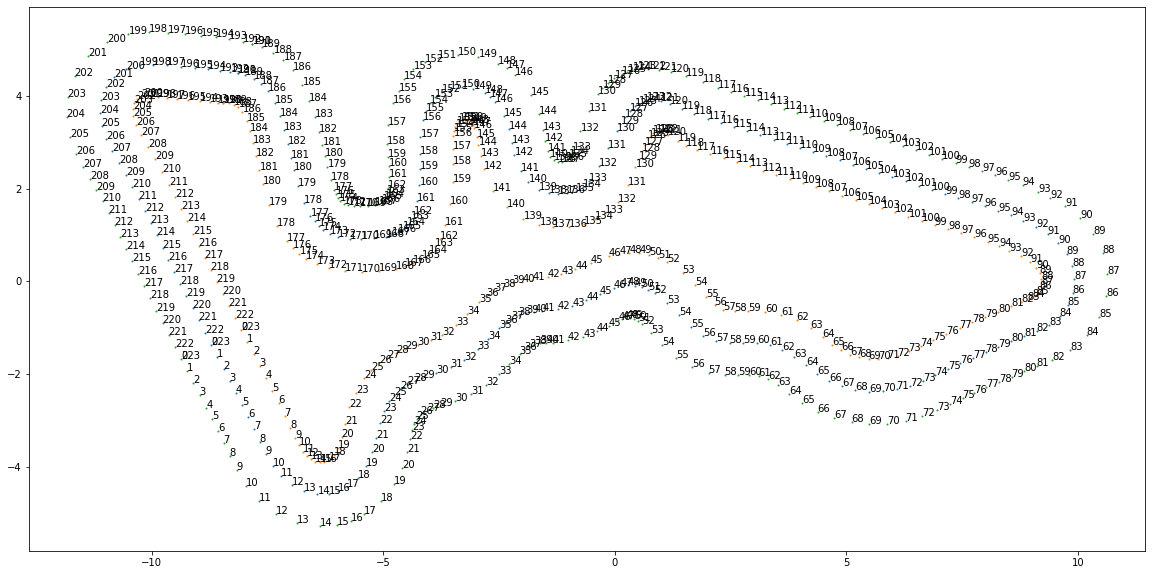

In [5]:
track: Track = tu.load_track("Austin")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [6]:
# AWS DeepRacer Console
#stream_name = 'sim-test' ## CHANGE This to your simulation application ID
#fname = 'logs/%s.log' %stream_name  # The log will be downloaded into the specified path
#cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /workspace/venv/logs/*.log
# fname = !ls -t /workspace/venv/logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [7]:
!ls logs

local-202011180747-robomaker.log
local-202011180747-sagemaker.log
local-202011180957-robomaker.log
local-202011180957-sagemaker.log
local-202011181420-robomaker.log
local-202011181420-sagemaker.log
local-202011181936-robomaker.log
local-202011181936-sagemaker.log
local-202011190453-robomaker.log
local-202011190453-sagemaker.log
local-202011191339-robomaker.log
local-202011191339-sagemaker.log
local-202011191801-robomaker.log
local-202011191801-sagemaker.log
local-202011192058-robomaker.log
local-202011192058-sagemaker.log
local-202011200448-robomaker.log
local-202011200448-sagemaker.log
local-202011200504-robomaker.log
local-202011200504-sagemaker.log
local-202011201523-robomaker.log
local-202011201523-sagemaker.log
local-202011201935-robomaker.log
local-202011201935-sagemaker.log
local-202011210443-robomaker.log
local-202011210443-sagemaker.log
local-202011211318-robomaker.log
local-202011211318-sagemaker.log
local-202011212137-robomaker.log
local-202011212137-sagemaker.log
local-2020

In [8]:
fname = 'logs/local-202011301951-robomaker.log'

In [9]:
EPISODES_PER_ITERATION = 40 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

In [10]:
df['throttle'].mean()

2.9278588415239963

In [11]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1          1.357829  3.303425
2          1.942799  3.235395
3          2.194457  3.227939
4          1.403892  3.276158
5          2.010155  3.349781
6          1.981313  3.292778
7          2.092461  3.150347
8          2.313813  3.262789
9          2.168935  3.358163
10         2.279395  3.264169
11         2.101845  3.216337
12         2.341035  3.230399
13         2.003385  3.289589
14         1.961393  3.257000
15         1.732719  3.257616
16         1.178175  3.324264
17         1.876352  3.172025
18         2.261704  3.254491
19         2.108313  3.341104
20         2.011699  3.250054
21         1.999186  3.373633
22         1.570529  3.147423
23         2.058216  3.161670
24         1.679763  3.180298
25         1.866778  3.216667
26         1.833589  3.212484
27         1.796837  3.223767
28         2.000302  3.294216
29         2.046114  3.149794
30         1.413364  3.098670
31         1.741031  3.210700
32         1.443240  3.142493
33         1.478832  3.102349
34         2.099320  3.311115
35         1.772488  3.128377
36         1.896960  3.153776
37         1.993474  3.122415
38         1.860428  3.090046
39         2.121122  3.149571
40         1.839333  2.922446
41         2.296774  3.108633
42         1.831316  3.183045
43         1.450272  3.099872
44         1.210482  3.007797
45         2.174272  3.224686
46         2.006641  2.998819
47         1.382784  3.125685
48         1.708606  3.018904
49         2.006762  3.141519
50         1.908065  3.170993
51         2.077072  3.246749
52         2.056292  3.144881
53         2.045275  3.143757
54         2.351700  3.132505
55         1.903887  3.026980
56         1.522013  3.096000
57         1.853746  3.008301
58         1.980253  3.006919
59         1.693122  2.936325
60         1.436674  2.911244
61         1.654477  2.936193
62         1.732521  3.037723
63         1.930231  2.980855
64         1.667764  2.922079
65         1.691086  2.941831
66         1.784532  2.880705
67         1.868714  2.959799
68         1.749892  2.889949
69         1.729670  2.890444
70         1.128862  2.930763
71         1.584371  2.859485
72         1.063537  2.817035
73         1.284162  2.967752
74         1.442643  2.925891
75         1.426569  2.962818
76         1.611686  2.936755
77         2.080232  3.068202
78         1.849836  2.935015
79         1.985968  3.044069
80         1.335150  3.055217
81         1.763630  3.003824
82         1.951870  2.951746
83         1.858527  2.981436
84         2.045501  2.924890
85         1.736595  3.083641
86         1.544130  2.987240
87         2.040719  3.059795
88         1.987104  3.003983
89         1.826326  2.934172
90         1.725805  2.909511
91         1.787699  2.892630
92         1.768652  2.899734
93         2.336952  3.036421
94         2.071638  3.159574
95         2.133296  2.865479
96         2.015660  2.932903
97         1.972414  2.895951
98         1.773626  2.933277
99         1.690913  2.932227
100        1.790409  2.923103
101        2.296877  2.890192
102        1.844918  2.970643
103        2.059458  2.926579
104        1.860666  2.963787
105        1.765145  2.984548
106        1.671941  3.044128
107        2.243708  2.998835
108        1.893568  2.867728
109        1.853455  2.876374
110        1.910900  3.066293
111        1.788971  2.957253
112        1.730021  2.859044
113        1.990553  2.874779
114        1.550172  2.871158
115        1.811961  2.965314
116        1.865649  2.985281
117        1.647448  2.872878
118        1.870794  2.885071
119        1.662581  2.964066
120        1.632576  2.889205
121        1.921286  2.893223
122        1.665067  2.792532
123        1.760904  2.896320
124        1.574157  2.827031
125        1.858516  2.933258
126        1.363164  2.953358
127        1.664626  2.871354
128        2.066615  2.837453
129        1.622650  2.862753
130        1.875931  2.942130
131        1.930697  2.878088
132        1.901077  2.8

new reward not found, using reward as its values
Number of episodes =  8046
Number of iterations =  202


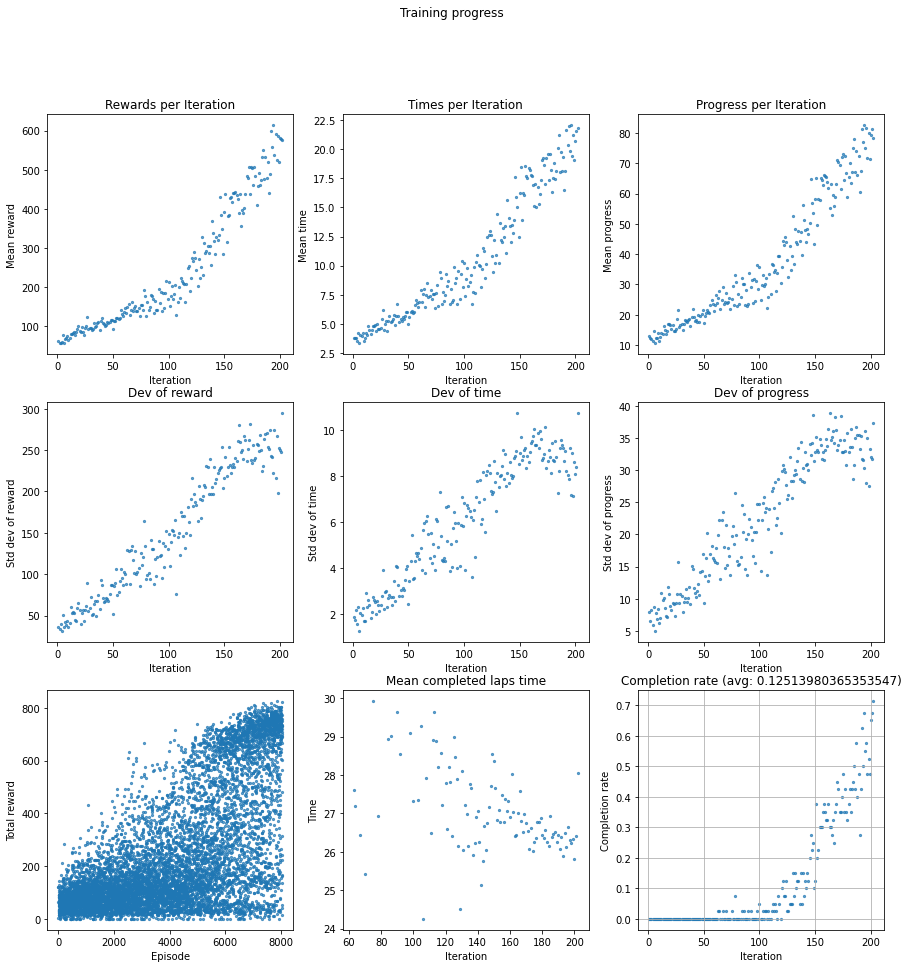

<Figure size 432x288 with 0 Axes>

In [12]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

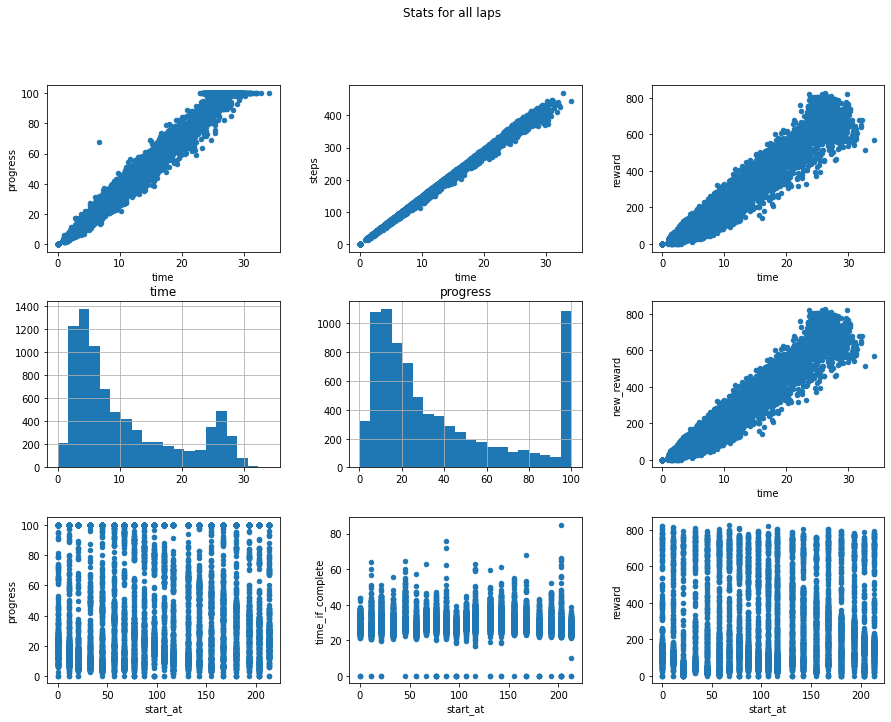

<Figure size 432x288 with 0 Axes>

In [13]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

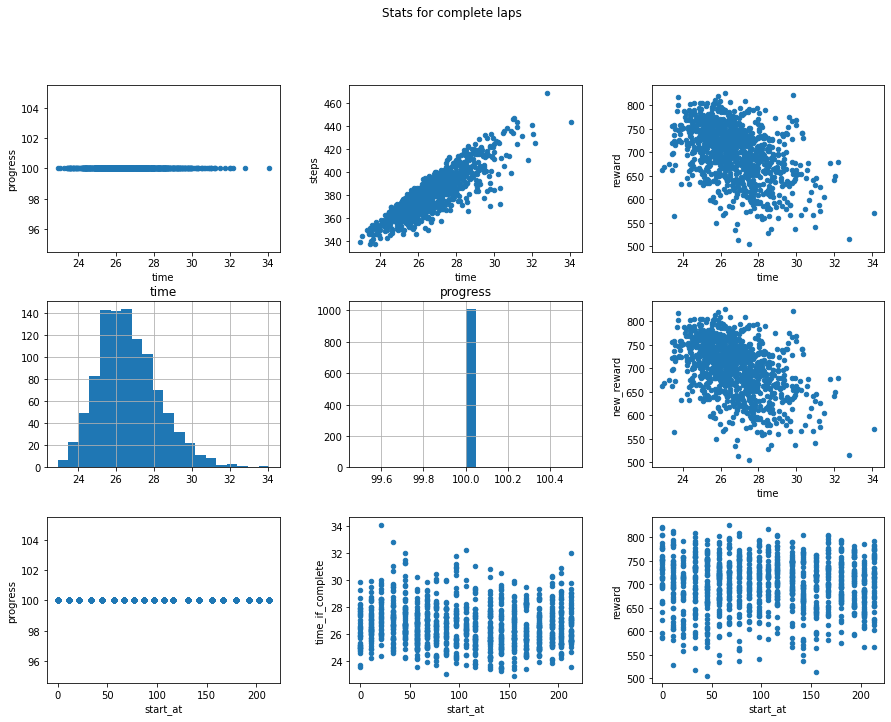

<Figure size 432x288 with 0 Axes>

In [14]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [15]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'reward')

iteration  episode  steps  start_at  progress       time  new_reward  \
7846        197     7846    368        67     100.0  26.228507    826.4797   
8040        202     8040    401         0     100.0  29.833344    821.3974   
7360        185     7360    359         0     100.0  25.843349    820.2346   
7630        191     7630    353       107     100.0  23.748504    818.6057   
7421        186     7421    369        11     100.0  25.700999    812.5859   
7047        177     7047    355        77     100.0  25.989426    810.0341   
7741        194     7741    386        11     100.0  27.290489    809.5809   
7083        178     7083    361        33     100.0  26.520960    808.2704   
7833        196     7833    356       142     100.0  24.931549    805.5046   
6940        174     6940    360         0     100.0  25.009836    804.7180   
7500        188     7500    362         0     100.0  24.609398    804.6103   
8011        201     8011    362       116     100.0  25.290442    804.1842   
7335        184     7335    359       167     100.0  25.663979    804.1351   
7925        199     7925    375        57     100.0  25.880791    803.6429   
7627        191     7627    371        77     100.0  25.595472    803.5764   
7995        200     7995    361       167     100.0  24.367360    803.2315   
7891        198     7891    356       116     100.0  23.770754    801.8213   
7583        190     7583    370        33     100.0  25.623469    799.5723   
6806        171     6806    371        67     100.0  25.204031    797.8792   
7966        200     7966    368        67     100.0  26.018220    796.3414   
7675        192     7675    363       167     100.0  25.555376    795.8878   
7084        178     7084    378        45     100.0  27.895504    794.5590   
6866        172     6866    380        67     100.0  27.019773    794.0888   
7509        188     7509    356        97     100.0  25.855359    794.0087   
7361        185     7361    364        11     100.0  24.871261    793.7923   
7276        182     7276    365       180     100.0  26.110928    793.3896   
7339        184     7339    370       213     100.0  25.829111    792.2470   
7189        180     7189    364        97     100.0  25.551323    791.9490   
7882        198     7882    391        21     100.0  27.505903    791.9234   
7956        199     7956    362       180     100.0  24.941361    791.9076   
7463        187     7463    393        33     100.0  27.697396    791.2462   
7991        200     7991    363       116     100.0  24.619636    790.6548   
7961        200     7961    361        11     100.0  26.245782    790.2253   
7505        188     7505    397        57     100.0  28.335824    789.5243   
7492        188     7492    356       131     100.0  24.337346    789.4699   
7035        176     7035    357       167     100.0  24.896915    789.1451   
7612        191     7612    355       131     100.0  24.076344    789.0232   
7840        197     7840    337         0     100.0  23.725318    788.3572   
7495        188     7495    374       167     100.0  25.888747    788.0254   
7776        195     7776    359       180     100.0  26.698686    787.6714   
7783        195     7783    395        33     100.0  27.367922    787.2418   
7521        189     7521    379        11     100.0  25.998619    786.7561   
7785        195     7785    357        57     100.0  24.496492    786.5821   
7726        194     7726    388        67     100.0  26.459648    785.6629   
7038        176     7038    360       203     100.0  24.431330    785.4725   
6703        168     6703    384        33     100.0  27.434195    785.2879   
7644        192     7644    369        45     100.0  26.204709    785.0773   
7969        200     7969    353        97     100.0  24.193608    784.6886   
7241        182     7241    381        11     100.0  28.018661    783.2110   
7681        193     7681    352        11     100.0  25.485534    783.1954   

      throttle    reward  t

In [16]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  episode  steps  start_at  progress       time  new_reward  \
2504         63     2504    392        45     100.0  27.606801    608.1743   
2549         64     2549    386        97     100.0  27.187615    632.3943   
2672         67     2672    384       131     100.0  26.446133    585.4116   
2796         70     2796    367       180     100.0  25.429446    597.6928   
2967         75     2967    430        77     100.0  29.928695    536.8277   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
2504  2.893878  608.1743         27.606801            608.1743      2nd   
2549  2.875907  632.3943         27.187615            632.3943      2nd   
2672  2.883594  585.4116         26.446133            585.4116      2nd   
2796  2.762670  597.6928         25.429446            597.6928      2nd   
2967  2.682093  536.8277         29.928695            536.8277      2nd   

      complete  
2504         1  
2549         1  
2672         1  
2796         1  
2967         1

In [17]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  episode  steps  start_at  progress       time  new_reward  \
8042        202     8042    411        21  100.0000  29.966955    757.9823   
8043        202     8043    396        33  100.0000  27.204685    665.3911   
8044        202     8044    381        45  100.0000  26.713891    751.3810   
8045        202     8045    382        57  100.0000  26.587036    733.5680   
8046        202     8046     75        67   18.9626   5.010354    161.0681   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
8042  2.812165  757.9823         29.966955          757.982300      5th   
8043  2.849495  665.3911         27.204685          665.391100      5th   
8044  2.794226  751.3810         26.713891          751.381000      5th   
8045  2.891099  733.5680         26.587036          733.568000      5th   
8046  3.168000  161.0681         26.422293          849.398817      5th   

      complete  
8042         1  
8043         1  
8044         1  
8045         1  
8046         0

In [18]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==5520]

iteration  episode  steps       x       y       yaw  steer  throttle  \
589300        139     5520      1 -8.6574 -1.4893  -62.6300    8.5       1.5   
589301        139     5520      2 -8.6528 -1.4944  -62.1825   -6.0       5.0   
589302        139     5520      3 -8.6383 -1.5216  -62.2206   -6.0       5.0   
589303        139     5520      4 -8.6289 -1.5434  -62.6794   -6.0       5.0   
589304        139     5520      5 -8.6065 -1.5974  -63.8876    0.0       8.0   
589305        139     5520      6 -8.5803 -1.6627  -65.1304   -3.4       5.0   
589306        139     5520      7 -8.5557 -1.7290  -66.5177   -3.4       5.0   
589307        139     5520      8 -8.5281 -1.8173  -68.7829    0.0       8.0   
589308        139     5520      9 -8.4943 -1.9286  -70.6172    3.6       2.6   
589309        139     5520     10 -8.4522 -2.0480  -70.6214    3.6       2.6   
589310        139     5520     11 -8.4027 -2.1743  -69.6809    3.6       2.6   
589311        139     5520     12 -8.3601 -2.2780  -68.8277    3.6       2.6   
589312        139     5520     13 -8.2924 -2.4344  -67.6119    0.9       7.0   
589313        139     5520     14 -8.2209 -2.5915  -66.4862    0.9       7.0   
589314        139     5520     15 -8.1632 -2.7239  -66.5632    0.9       7.0   
589315        139     5520     16 -8.1036 -2.8664  -66.9925    3.6       2.6   
589316        139     5520     17 -8.0380 -3.0211  -67.0184    3.6       2.6   
589317        139     5520     18 -7.9262 -3.2545  -64.9729    3.6       2.6   
589318        139     5520     19 -7.8342 -3.4326  -63.5131    3.6       2.6   
589319        139     5520     20 -7.7686 -3.5494  -62.1894   15.2       2.4   
589320        139     5520     21 -7.6593 -3.7312  -60.0449   15.2       2.4   
589321        139     5520     22 -7.5839 -3.8440  -58.2463   19.0       1.5   
589322        139     5520     23 -7.4856 -3.9717  -55.0224   19.0       1.5   
589323        139     5520     24 -7.3632 -4.1045  -50.4093   15.2       2.4   
589324        139     5520     25 -7.3117 -4.1529  -48.3708   19.0       1.5   
589325        139     5520     26 -7.1524 -4.2762  -41.5323   30.0       1.2   
589326        139     5520     27 -7.0711 -4.3249  -37.7954   30.0       1.2   
589327        139     5520     28 -6.9804 -4.3690  -33.2631   30.0       1.2   
589328        139     5520     29 -6.9011 -4.3990  -29.2071    8.5       1.5   
589329        139     5520     30 -6.8119 -4.4213  -23.9459    8.5       1.5   
589330        139     5520     31 -6.7018 -4.4354  -17.1935    8.5       1.5   
589331        139     5520     32 -6.5908 -4.4392  -11.0627   30.0       1.2   
589332        139     5520     33 -6.5143 -4.4327   -6.0546    8.5       1.5   
589333        139     5520     34 -6.4024 -4.4096    1.1836    8.5       1.5   
589334        139     5520     35 -6.3073 -4.3796    7.1816   19.0       1.5   
589335        139     5520     36 -6.2352 -4.3498   11.7746    8.5       1.5   
589336        139     5520     37 -6.1395 -4.3012   17.7285  -23.0       1.4   
589337        139     5520     38 -6.0554 -4.2481   23.1863   -2.7       2.5   
589338        139     5520     39 -5.9598 -4.1803   28.3111    8.5       1.5   
589339        139     5520     40 -5.8774 -4.1127   32.7008   -2.7       2.5   
589340        139     5520     41 -5.8088 -4.0516   35.7696    3.6       2.6   
589341        139     5520     42 -5.7145 -3.9583   39.9716   -0.3       7.0   
589342        139     5520     43 -5.6294 -3.8619   43.9566  -12.1       2.5   
589343        139     5520     44 -5.5176 -3.7294   47.3854  -12.1       2.5   
589344        139     5520     45 -5.4288 -3.6267   48.2473    0.9       7.0   
589345        139     5520     46 -5.3123 -3.4874   49.3554    0.9       7.0   
589346        139     5520     47 -5.2399 -3.3979   50.0744   -3.4       5.0   
589347        139     5520     48 -5.0716 -3.1849   51.3545   -3.4       5.0   
589348        139     5520     49 -4.9860 -3.0758   51.6536   -3.4       5.0   
589349  

# Extract Action Space List from LOG file

In [19]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steer'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.throttle.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steer','throttle'].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2))
    asl[j].rel_thr = AS.throttle[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steer.min()*dgr_norm,2)
asPlotXmax = round(df.steer.max()*dgr_norm,2)
asPlotYmin = round(df.throttle.min(),2)
asPlotYmax = round(df.throttle.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-30.0		1.2
1		-23.0		1.4
2		-18.9		1.6
3		-12.1		2.5
4		-8.0		3.5
5		-6.0		5.0
6		-3.4		5.0
7		-2.7		2.5
8		-0.5		4.9
9		-0.3		7.0
10		0.0		8.0
11		0.9		7.0
12		3.6		2.6
13		6.4		4.0
14		7.7		3.5
15		8.5		1.5
16		12.0		3.7
17		15.2		2.4
18		19.0		1.5
19		23.0		1.4
20		30.0		1.2


## Function definitions

In [20]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steer']*(dgr_norm), episode_data['throttle'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steer']*dgr_norm, bins=60)
    ax4.hist(episode_data['throttle'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

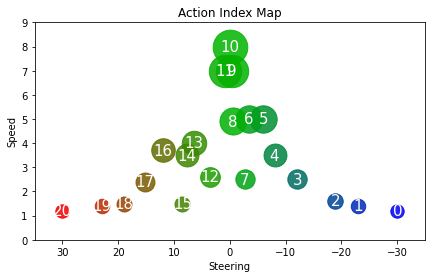

In [21]:
plot_index_map(asl)    

# Analysing data from all episodes

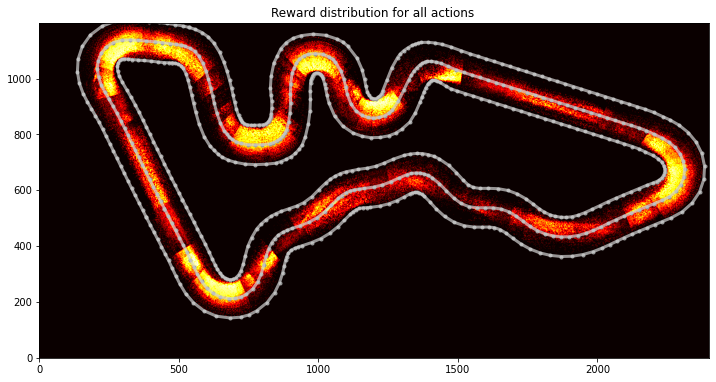

<Figure size 432x288 with 0 Axes>

In [22]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


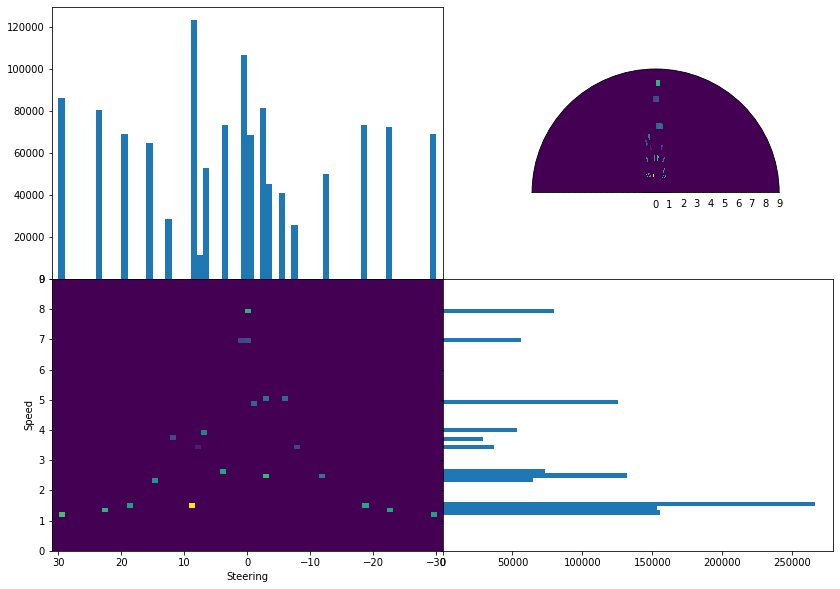

In [23]:
plot_4_hist(df)

Histogram for all episodes:


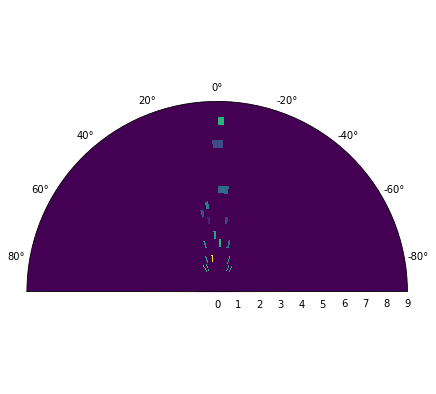

In [24]:
plot_polar_hist(df)



# Analyzing specific iteration





In [25]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()-1     # last iteration

In [26]:
df

iteration  episode  steps       x       y       yaw  steer  throttle  \
0                1        0      3 -8.6515 -1.4991  -62.4672    0.0       8.0   
1                1        0      4 -8.6380 -1.5224  -62.2581   -0.3       7.0   
2                1        0      5 -8.6140 -1.5627  -61.6304   -6.0       5.0   
3                1        0      6 -8.5789 -1.6184  -60.6003    6.4       4.0   
4                1        0      7 -8.5353 -1.6956  -60.6201    0.0       8.0   
...            ...      ...    ...     ...     ...       ...    ...       ...   
1224066        202     8046     71  6.6829  1.8641  162.7131    0.9       7.0   
1224067        202     8046     72  6.5115  1.9168  162.8347    0.0       8.0   
1224068        202     8046     73  6.2297  2.0016  163.0183    0.0       8.0   
1224069        202     8046     74  5.9512  2.0858  163.0177    0.0       8.0   
1224070        202     8046     75  5.6491  2.1749  163.2514    0.0       8.0   

         action  reward  done on_track  progress  closest_waypoint  track_len  \
0          10.0  1.9967     0     True    0.2560                 1      59.35   
1           9.0  1.9990     0     True    0.3012                 1      59.35   
2           5.0  3.2204     0     True    0.3801                 1      59.35   
3          13.0  0.0010     0     True    0.4907                 1      59.35   
4          10.0  1.9828     0     True    0.6400                 1      59.35   
...         ...     ...   ...      ...       ...               ...        ...   
1224066    11.0  0.0010     0     True   17.1439               100      59.35   
1224067    10.0  3.7696     0     True   17.4461               101      59.35   
1224068    10.0  3.7614     0     True   17.9418               102      59.35   
1224069    10.0  3.7558     0     True   18.4319               103      59.35   
1224070    10.0  3.7469     0     True   18.9626               104      59.35   

                  timestamp  new_reward  
0        1606628439.2954187      1.9967  
1        1606628439.3770077      1.9990  
2        1606628439.4512663      3.2204  
3         1606628439.535296      0.0010  
4        1606628439.6138356      1.9828  
...                     ...         ...  
1224066   1606733505.358031      0.0010  
1224067  1606733505.4391685      3.7696  
1224068  1606733505.5194137      3.7614  
1224069  1606733505.6137638      3.7558  
1224070  1606733505.6491373      3.7469  

[1224071 rows x 17 columns]

Iteration: 201


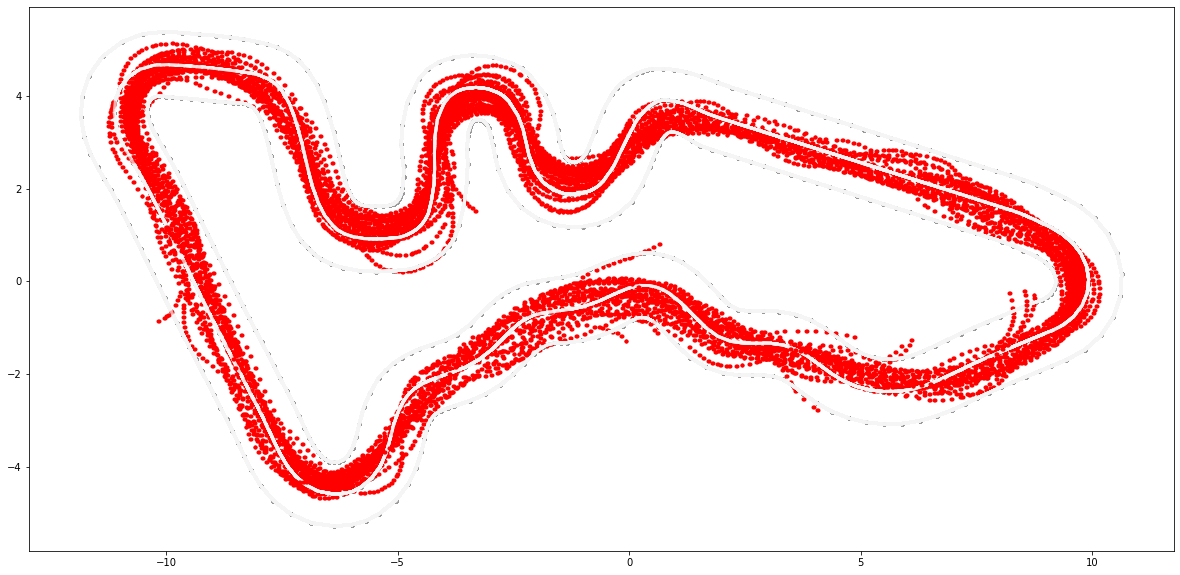

In [27]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 201


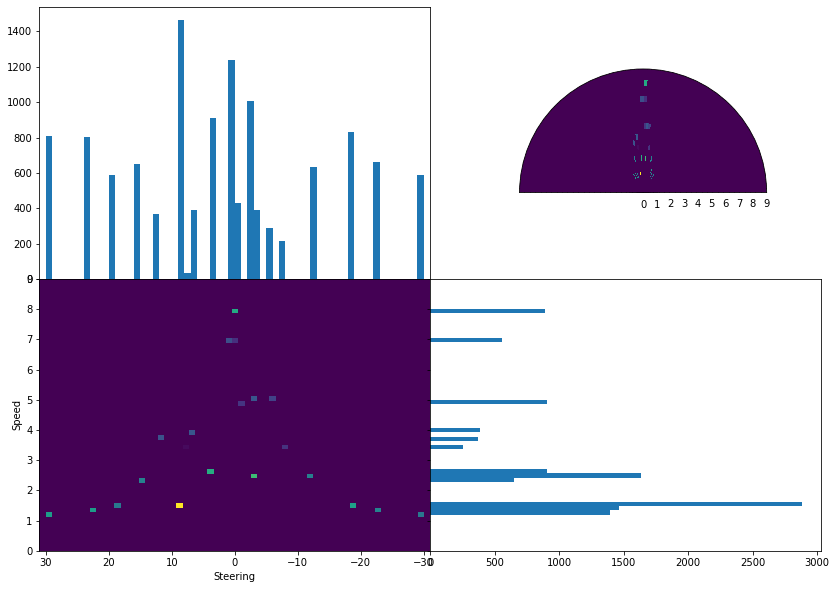

In [28]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 201


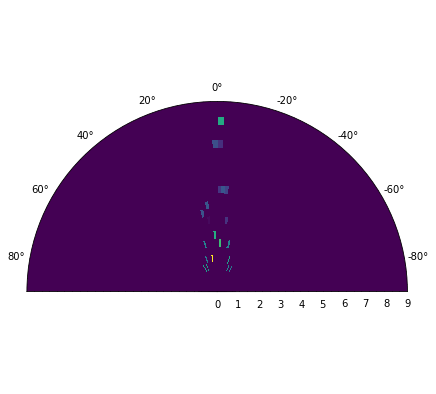

In [29]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [30]:
### choose episode id
#EPZ = 15
EPZ = df['episode'].max()
ITZ = df['iteration'].max()-1
#EPZ = 60
#EPZ = 442

<AxesSubplot:>

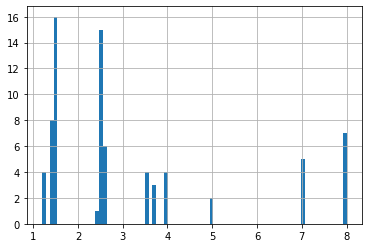

In [31]:
df[df['episode']==EPZ]['throttle'].hist(bins=80)

<AxesSubplot:>

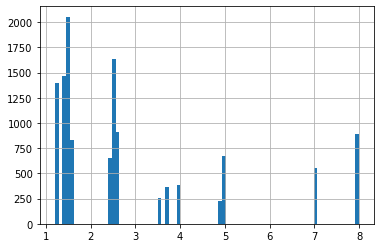

In [32]:
df[df['iteration']==ITZ]['throttle'].hist(bins=80)

<AxesSubplot:>

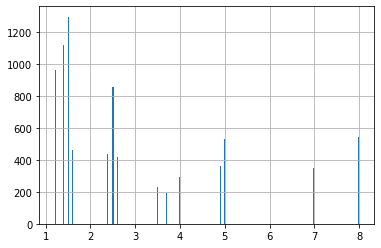

In [33]:
df[df['iteration']==140]['throttle'].hist(bins=300)

<AxesSubplot:>

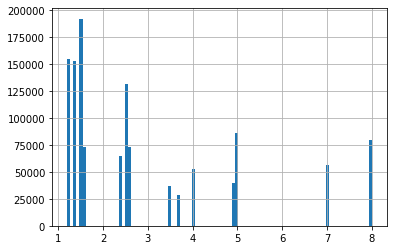

In [34]:
df['throttle'].hist(bins=100)

<AxesSubplot:>

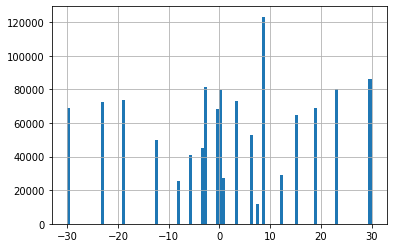

In [35]:
df['steer'].hist(bins=100)

In [36]:
df['throttle'].mean()

2.9278588415239963

In [37]:
df.groupby("iteration").mean()

episode       steps         x         y        yaw     steer  \
iteration                                                                     
1            19.133452   35.172598 -1.441217  0.523280  12.405046  1.357829   
2            62.005418   33.534989 -1.770734  0.970084  14.373050  1.942799   
3           100.405007   36.473402 -1.347234  0.768043  13.358569  2.194457   
4           139.097044   30.689163 -1.796356  0.829208   9.628427  1.403892   
5           179.768618   40.606133 -1.550883  0.666095  13.320971  2.010155   
6           219.068687   28.391919 -1.181186  0.721568   7.584306  1.981313   
7           261.006499   35.964038 -2.085608  0.639297  10.814624  2.092461   
8           299.511111   35.427451 -1.966223  0.634642   5.594054  2.313813   
9           339.929019   37.912735 -1.025036  0.820350  16.356755  2.168935   
10          379.619597   31.702690 -2.010204  0.723094  10.015751  2.279395   
11          419.291179   33.656166 -1.230803  1.055990   7.938445  2.101845   
12          462.337408   44.833741 -2.453047  0.690239  15.332066  2.341035   
13          499.128963   38.026135 -1.777222  0.890277   9.382002  2.003385   
14          538.537143   45.245714 -1.140508  0.345815  11.155394  1.961393   
15          579.989470   42.252727 -1.955975  0.772948  12.152401  1.732719   
16          619.464256   35.884777 -1.864328  0.721171   7.123805  1.178175   
17          659.315301   39.067620 -1.792459  0.823284  12.639206  1.876352   
18          698.728076   46.708274 -1.001124  0.503671  12.806484  2.261704   
19          739.968518   45.543332 -2.486959  0.560005   9.984387  2.108313   
20          780.530233   43.586404 -1.849274  0.493436  10.964037  2.011699   
21          819.019775   38.702986 -0.684519  0.848631  20.518279  1.999186   
22          860.104808   45.070218 -2.035778  0.943888  16.687758  1.570529   
23          900.086148   41.957495 -2.517329  0.632734   7.214944  2.058216   
24          940.305662   39.463275 -1.812310  0.772499   5.238980  1.679763   
25          979.337398   42.898744 -2.035982  0.846225  15.921626  1.866778   
26         1019.853448   49.515964 -2.411338  0.334716   7.635095  1.833589   
27         1060.644913   60.859219 -2.092881  0.668746   8.375262  1.796837   
28         1101.245747   41.145936 -2.598870  0.506695  12.407678  2.000302   
29         1140.598349   48.758941 -1.861629  0.850907  13.210023  2.046114   
30         1179.272606   49.503324 -3.057743  0.548704   4.855993  1.413364   
31         1220.171125   40.049961 -2.081988  0.558818  13.733746  1.741031   
32         1260.028533   46.481658 -1.488225  0.690147   6.604636  1.443240   
33         1300.016069   49.898949 -2.594704  0.738713   7.586101  1.478832   
34         1339.403127   46.768185 -1.604409  0.597676  11.726763  2.099320   
35         1378.796075   45.559548 -1.738615  0.650138  10.860531  1.772488   
36         1420.336885   50.100282 -2.106139  0.507913  14.566399  1.896960   
37         1460.712107   55.063129 -2.419260  0.642724  15.080601  1.993474   
38         1500.486856   45.260077 -2.980867  0.644342   1.874183  1.860428   
39         1540.285408   60.977928 -2.791935  0.664876   5.899140  2.121122   
40         1579.369796   65.438324 -2.310184  0.666844   7.674684  1.839333   
41         1620.319816   52.813518 -1.851238  0.703178  12.665299  2.296774   
42         1660.051197   48.093418 -2.068745  0.637100  10.533453  1.831316   
43         1699.704640   51.174400 -2.946168  0.740805   7.288752  1.450272   
44         1740.620188   49.262051 -2.306647  1.022725   9.219613  1.210482   
45         1780.283655   53.536032 -2.063512  0.405221   5.728530  2.174272   
46         1819.299808   51.206258 -2.008338  0.771119  10.376299  2.006641   
47         1859.692331   55.627964 -2.143126  0.787396  10.303065  1.382784   
48         1902.333046   62.028973 -2.557710  0.577959   0.772034  1.708606   
49         1940.121777   63.689398 -2.254573  0.451942   7.313259

In [38]:
(df[df['on_track']=='False'].groupby("closest_waypoint").count() / df[df['on_track']=='False'].count()["iteration"]) ['iteration']


closest_waypoint
0      0.001283
1      0.002035
2      0.002013
3      0.001592
4      0.001924
5      0.001880
6      0.001570
7      0.001504
8      0.001261
9      0.001261
10     0.000818
11     0.000863
12     0.001150
13     0.001615
14     0.002300
15     0.002853
16     0.002521
17     0.003716
18     0.003959
19     0.003185
20     0.002433
21     0.001747
22     0.002322
23     0.004114
24     0.005131
25     0.005153
26     0.003008
27     0.003494
28     0.003317
29     0.003583
30     0.003185
31     0.004224
32     0.008780
33     0.012164
34     0.012120
35     0.007674
36     0.003738
37     0.003096
38     0.002366
39     0.004003
40     0.006856
41     0.007099
42     0.007453
43     0.007873
44     0.010439
45     0.011854
46     0.007343
47     0.003517
48     0.003716
49     0.001239
50     0.003406
51     0.004423
52     0.010837
53     0.014575
54     0.011766
55     0.011921
56     0.012916
57     0.014000
58     0.012054
59     0.007409
60     0.004445
61     

In [39]:
df.groupby("closest_waypoint").mean()

iteration      episode       steps          x         y  \
closest_waypoint                                                             
0                 121.597963  4844.181531  107.863062  -8.717247 -1.462063   
1                 118.744585  4728.530933   94.080256  -8.617311 -1.625530   
2                 122.745759  4890.505397  116.117965  -8.481958 -1.898900   
3                 123.642987  4927.020326  121.296237  -8.349652 -2.162237   
4                 124.324392  4954.332710  125.034934  -8.215850 -2.421648   
5                 126.018934  5022.204775  128.280099  -8.071392 -2.677083   
6                 127.246537  5071.389681  132.325838  -7.937127 -2.938132   
7                 128.150558  5107.557972  132.651598  -7.798951 -3.199142   
8                 127.905088  5097.700108  135.688741  -7.656411 -3.455597   
9                 129.957583  5179.707962  138.700724  -7.499733 -3.702275   
10                129.955473  5179.680212  139.748871  -7.332491 -3.938514   
11                122.320383  4871.383941  100.861028  -7.157394 -4.144943   
12                126.857296  5054.316561  122.753131  -6.916132 -4.298614   
13                127.011341  5060.884027  128.843265  -6.669587 -4.391031   
14                126.582437  5043.838283  132.334775  -6.423296 -4.409554   
15                125.318153  4993.300722  135.609296  -6.214333 -4.404875   
16                124.263002  4951.399223  137.738294  -6.041422 -4.371785   
17                126.108624  5025.001658  139.677308  -5.881638 -4.261009   
18                126.346257  5034.537894  142.286049  -5.687592 -4.117869   
19                127.289549  5072.156361  144.525640  -5.494659 -3.915002   
20                128.725833  5129.477754  147.054624  -5.301846 -3.672589   
21                123.573554  4921.632576  118.385775  -5.127466 -3.376125   
22                122.706288  4887.241608  121.770917  -4.999265 -3.104749   
23                120.507328  4799.376091  125.776552  -4.887743 -2.855460   
24                117.164156  4665.866416  126.080860  -4.819750 -2.643271   
25                117.221214  4668.100397  128.344016  -4.720299 -2.488313   
26                117.839448  4693.369395  133.105049  -4.596065 -2.372559   
27                121.192190  4827.261646  137.196374  -4.437343 -2.305385   
28                123.483523  4919.022431  136.721407  -4.293191 -2.206550   
29                126.837416  5052.901817  139.730936  -4.107612 -2.102528   
30                128.354347  5113.706449  141.153353  -3.856511 -1.957968   
31                129.186577  5146.828356  142.669347  -3.558689 -1.825544   
32                127.996194  5099.288628  142.257117  -3.237434 -1.702964   
33                121.188875  4825.038594  103.310479  -2.943515 -1.516996   
34                125.276936  4989.593598  123.960417  -2.682427 -1.292347   
35                128.079545  5102.055961  130.910377  -2.468597 -1.097868   
36                130.530516  5200.073312  133.923077  -2.328474 -0.952640   
37                130.295891  5190.379947  133.813419  -2.198144 -0.862550   
38                131.227689  5227.917620  136.141114  -2.065335 -0.761342   
39                131.799314  5250.854202  135.742710  -1.902268 -0.714006   
40                131.203125  5226.666667  139.403799  -1.727515 -0.727646   
41                131.672049  5245.777657  139.088152  -1.521246 -0.643325   
42                132.589591  5282.315403  142.277157  -1.235776 -0.581558   
43                133.549337  5320.562592  143.883284  -0.911781 -0.531123   
44                135.606045  5402.944794  148.462614  -0.598272 -0.452065   
45                123.760009  4927.668120   98.582769  -0.306467 -0.341171   
46                127.891824  5093.351363  119.038902  -0.030444 -0.267514   
47                127.000370  5057.883747  120.194002   0.145005 -0.217219   
48                128.326222  5110.930178  121.463538   0.286034 -0.221548   
49                123.581998  4920.927898

In [40]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

steer  throttle
iteration                    
1          1.357829  3.303425
2          1.942799  3.235395
3          2.194457  3.227939
4          1.403892  3.276158
5          2.010155  3.349781
6          1.981313  3.292778
7          2.092461  3.150347
8          2.313813  3.262789
9          2.168935  3.358163
10         2.279395  3.264169
11         2.101845  3.216337
12         2.341035  3.230399
13         2.003385  3.289589
14         1.961393  3.257000
15         1.732719  3.257616
16         1.178175  3.324264
17         1.876352  3.172025
18         2.261704  3.254491
19         2.108313  3.341104
20         2.011699  3.250054
21         1.999186  3.373633
22         1.570529  3.147423
23         2.058216  3.161670
24         1.679763  3.180298
25         1.866778  3.216667
26         1.833589  3.212484
27         1.796837  3.223767
28         2.000302  3.294216
29         2.046114  3.149794
30         1.413364  3.098670
31         1.741031  3.210700
32         1.443240  3.142493
33         1.478832  3.102349
34         2.099320  3.311115
35         1.772488  3.128377
36         1.896960  3.153776
37         1.993474  3.122415
38         1.860428  3.090046
39         2.121122  3.149571
40         1.839333  2.922446
41         2.296774  3.108633
42         1.831316  3.183045
43         1.450272  3.099872
44         1.210482  3.007797
45         2.174272  3.224686
46         2.006641  2.998819
47         1.382784  3.125685
48         1.708606  3.018904
49         2.006762  3.141519
50         1.908065  3.170993
51         2.077072  3.246749
52         2.056292  3.144881
53         2.045275  3.143757
54         2.351700  3.132505
55         1.903887  3.026980
56         1.522013  3.096000
57         1.853746  3.008301
58         1.980253  3.006919
59         1.693122  2.936325
60         1.436674  2.911244
61         1.654477  2.936193
62         1.732521  3.037723
63         1.930231  2.980855
64         1.667764  2.922079
65         1.691086  2.941831
66         1.784532  2.880705
67         1.868714  2.959799
68         1.749892  2.889949
69         1.729670  2.890444
70         1.128862  2.930763
71         1.584371  2.859485
72         1.063537  2.817035
73         1.284162  2.967752
74         1.442643  2.925891
75         1.426569  2.962818
76         1.611686  2.936755
77         2.080232  3.068202
78         1.849836  2.935015
79         1.985968  3.044069
80         1.335150  3.055217
81         1.763630  3.003824
82         1.951870  2.951746
83         1.858527  2.981436
84         2.045501  2.924890
85         1.736595  3.083641
86         1.544130  2.987240
87         2.040719  3.059795
88         1.987104  3.003983
89         1.826326  2.934172
90         1.725805  2.909511
91         1.787699  2.892630
92         1.768652  2.899734
93         2.336952  3.036421
94         2.071638  3.159574
95         2.133296  2.865479
96         2.015660  2.932903
97         1.972414  2.895951
98         1.773626  2.933277
99         1.690913  2.932227
100        1.790409  2.923103
101        2.296877  2.890192
102        1.844918  2.970643
103        2.059458  2.926579
104        1.860666  2.963787
105        1.765145  2.984548
106        1.671941  3.044128
107        2.243708  2.998835
108        1.893568  2.867728
109        1.853455  2.876374
110        1.910900  3.066293
111        1.788971  2.957253
112        1.730021  2.859044
113        1.990553  2.874779
114        1.550172  2.871158
115        1.811961  2.965314
116        1.865649  2.985281
117        1.647448  2.872878
118        1.870794  2.885071
119        1.662581  2.964066
120        1.632576  2.889205
121        1.921286  2.893223
122        1.665067  2.792532
123        1.760904  2.896320
124        1.574157  2.827031
125        1.858516  2.933258
126        1.363164  2.953358
127        1.664626  2.871354
128        2.066615  2.837453
129        1.622650  2.862753
130        1.875931  2.942130
131        1.930697  2.878088
132        1.901077  2.8

In [41]:
df[df['episode']==EPZ]

iteration  episode  steps       x       y       yaw  steer  throttle  \
1223996        202     8046      1  4.8113 -2.2243  -22.9675    6.4       4.0   
1223997        202     8046      2  4.8201 -2.2246  -22.2987    7.7       3.5   
1223998        202     8046      3  4.8397 -2.2302  -21.7244    7.7       3.5   
1223999        202     8046      4  4.8794 -2.2404  -20.4266    8.5       1.5   
1224000        202     8046      5  4.9152 -2.2484  -19.2643    8.5       1.5   
1224001        202     8046      6  4.9845 -2.2613  -16.9103    6.4       4.0   
1224002        202     8046      7  5.0752 -2.2717  -13.3360   15.2       2.4   
1224003        202     8046      8  5.1438 -2.2756  -10.5306   12.0       3.7   
1224004        202     8046      9  5.2617 -2.2773   -6.4109   12.0       3.7   
1224005        202     8046     10  5.4153 -2.2668   -0.7776    6.4       4.0   
1224006        202     8046     11  5.4971 -2.2568    2.0821    6.4       4.0   
1224007        202     8046     12  5.6757 -2.2235    7.4145   -8.0       3.5   
1224008        202     8046     13  5.8876 -2.1695   13.1970   -0.3       7.0   
1224009        202     8046     14  6.0142 -2.1308   15.4252    0.9       7.0   
1224010        202     8046     15  6.1881 -2.0654   19.0019    3.6       2.6   
1224011        202     8046     16  6.3734 -1.9775   23.9281    0.0       8.0   
1224012        202     8046     17  6.6082 -1.8449   28.4965   -2.7       2.5   
1224013        202     8046     18  6.7326 -1.7671   30.7460  -12.1       2.5   
1224014        202     8046     19  6.9347 -1.6430   31.4132  -12.1       2.5   
1224015        202     8046     20  7.0591 -1.5744   30.1434  -12.1       2.5   
1224016        202     8046     21  7.2224 -1.4910   28.2304  -12.1       2.5   
1224017        202     8046     22  7.3480 -1.4347   26.2441  -12.1       2.5   
1224018        202     8046     23  7.5175 -1.3691   23.1707   -2.7       2.5   
1224019        202     8046     24  7.6427 -1.3270   21.0034   -2.7       2.5   
1224020        202     8046     25  7.8551 -1.2619   18.2758   -2.7       2.5   
1224021        202     8046     26  7.9625 -1.2320   17.1428   -2.7       2.5   
1224022        202     8046     27  8.1518 -1.1867   14.8062    3.6       2.6   
1224023        202     8046     28  8.3246 -1.1448   14.0994    3.6       2.6   
1224024        202     8046     29  8.4814 -1.1040   14.3379    8.5       1.5   
1224025        202     8046     30  8.6648 -1.0464   16.3687    3.6       2.6   
1224026        202     8046     31  8.7864 -1.0063   17.1372   23.0       1.4   
1224027        202     8046     32  8.9113 -0.9608   18.4757   23.0       1.4   
1224028        202     8046     33  9.0733 -0.8844   22.4665   30.0       1.2   
1224029        202     8046     34  9.1501 -0.8391   25.2658   30.0       1.2   
1224030        202     8046     35  9.2696 -0.7513   30.9346   23.0       1.4   
1224031        202     8046     36  9.3490 -0.6738   36.3742   23.0       1.4   
1224032        202     8046     37  9.4082 -0.5997   41.7001   23.0       1.4   
1224033        202     8046     38  9.4693 -0.5042   48.1383   23.0       1.4   
1224034        202     8046     39  9.4981 -0.4493   51.6311   30.0       1.2   
1224035        202     8046     40  9.5434 -0.3421   58.0955    8.5       1.5   
1224036        202     8046     41  9.5657 -0.2648   63.0147   19.0       1.5   
1224037        202     8046     42  9.5794 -0.1844   68.4378    8.5       1.5   
1224038        202     8046     43  9.5891 -0.0630   75.8742   30.0       1.2   
1224039        202     8046     44  9.5865  0.0199   80.9777   23.0       1.4   
1224040        202     8046     45  9.5732  0.1333   87.4640   23.0       1.4   
1224041        202     8046     46  9.5576  0.2031   91.6748   19.0       1.5   
1224042        202     8046     47  9.5259  0.3011   97.8453    8.5       1.5   
1224043        202     8046     48  9.4849  0.3986  103.6222   19.0       1.5   
1224044        202     8046     49  9.43

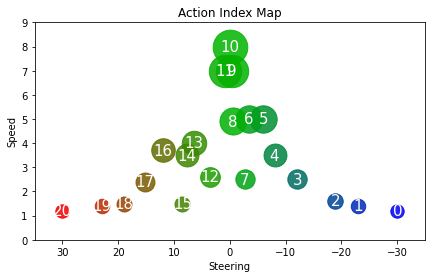

In [42]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


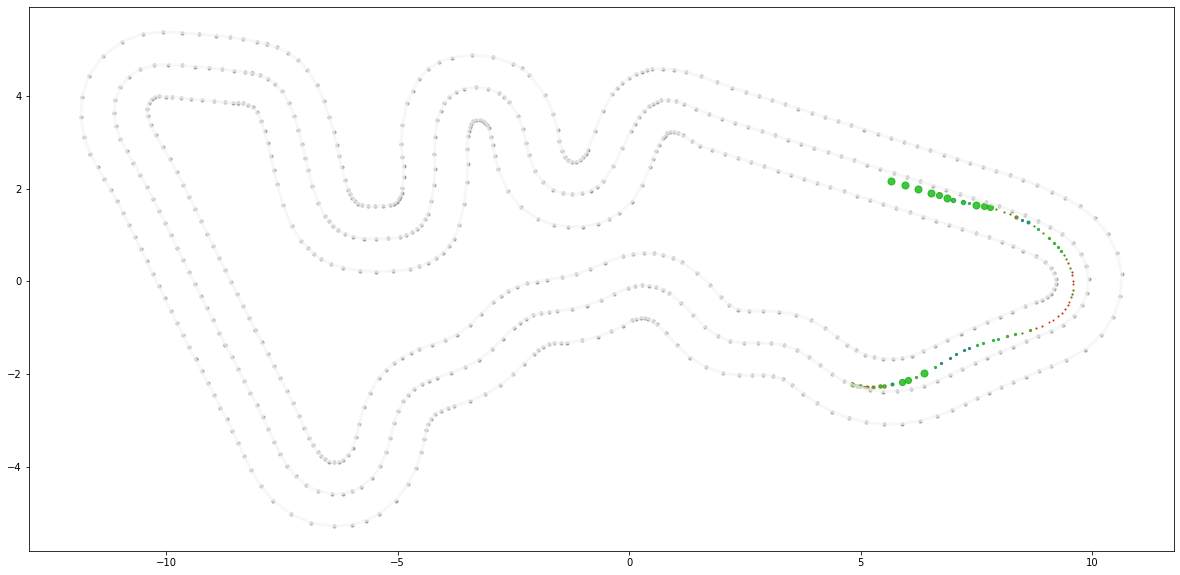

In [43]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
#EPZ = 31
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 8046


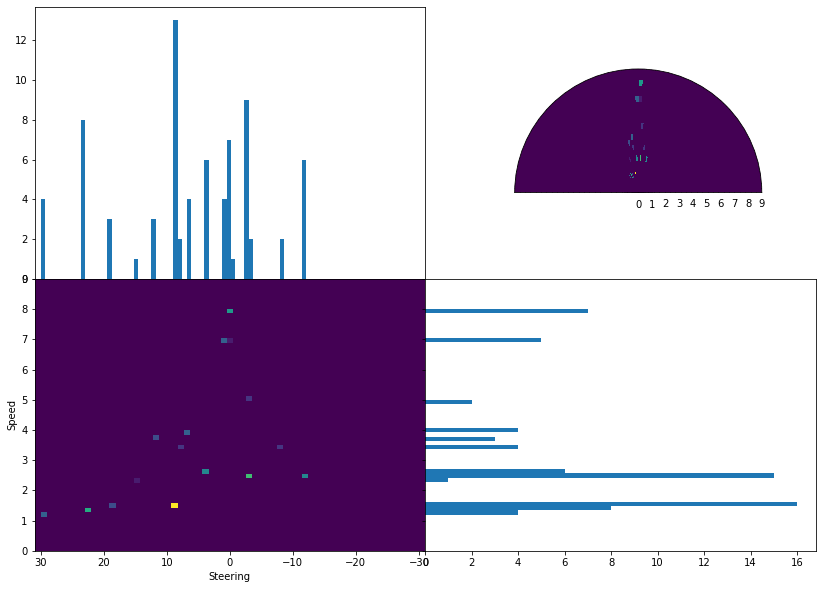

In [44]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 8046


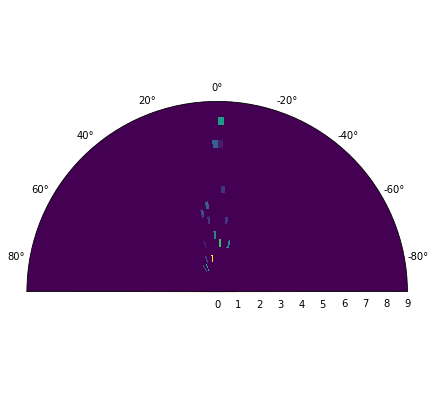

In [45]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot:xlabel='closest_waypoint'>

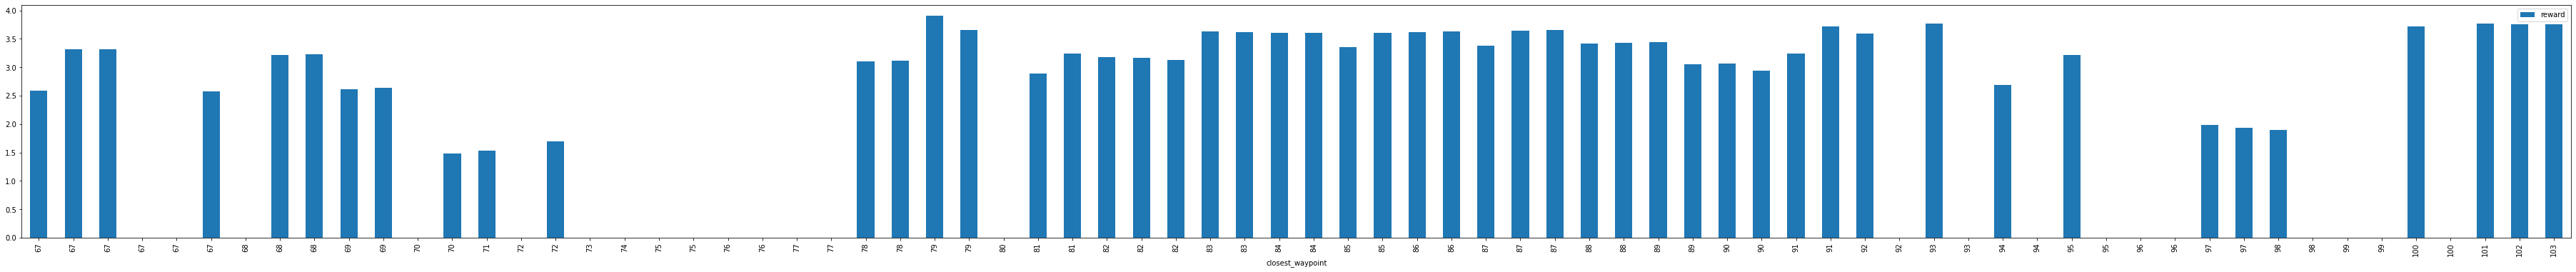

In [46]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(64, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.2


<Figure size 432x288 with 0 Axes>

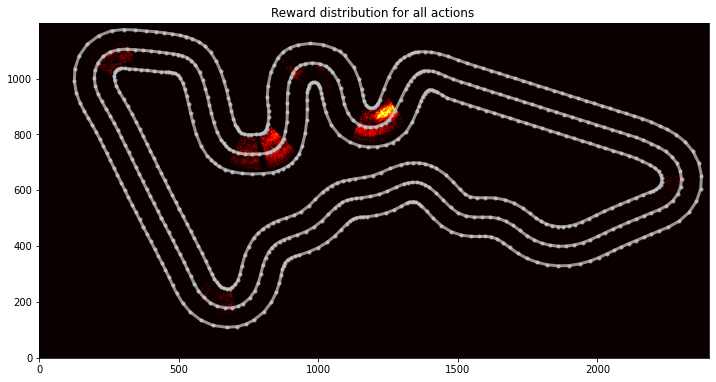

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 1: steering: -23.0, throttle: 1.4


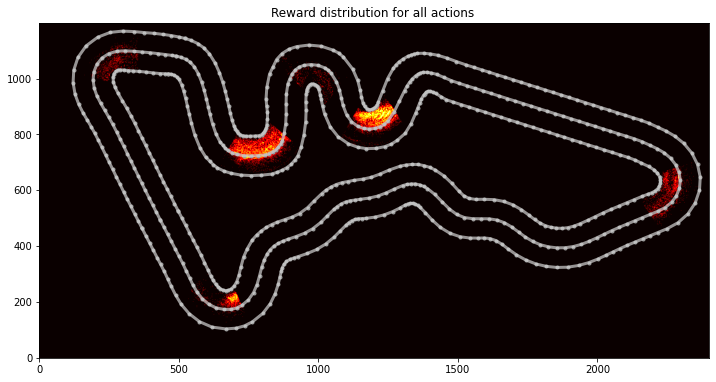

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 2: steering: -18.9, throttle: 1.6


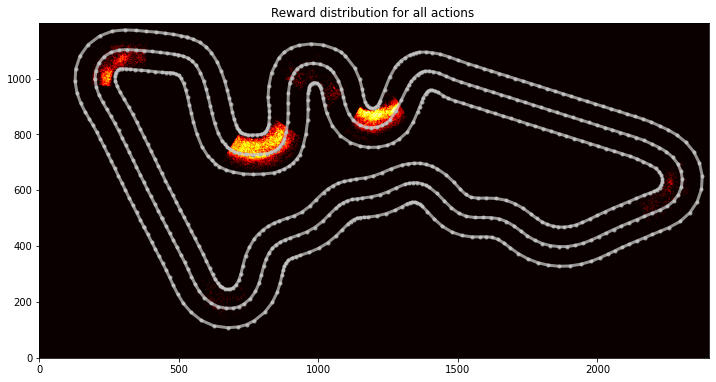

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 3: steering: -12.1, throttle: 2.5


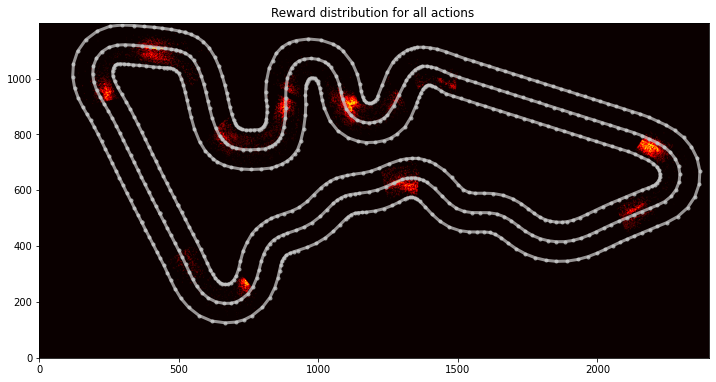

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 4: steering: -8.0, throttle: 3.5


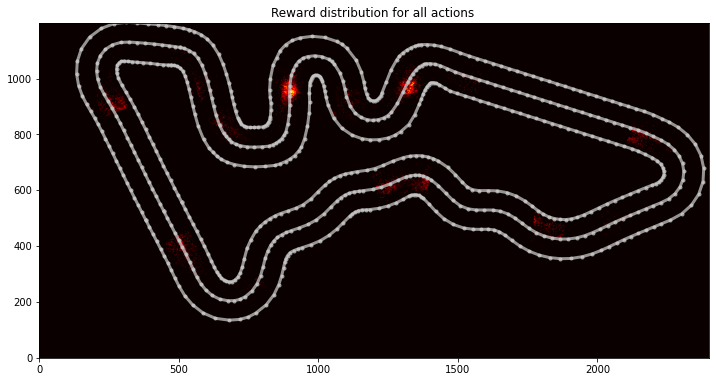

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 5: steering: -6.0, throttle: 5.0


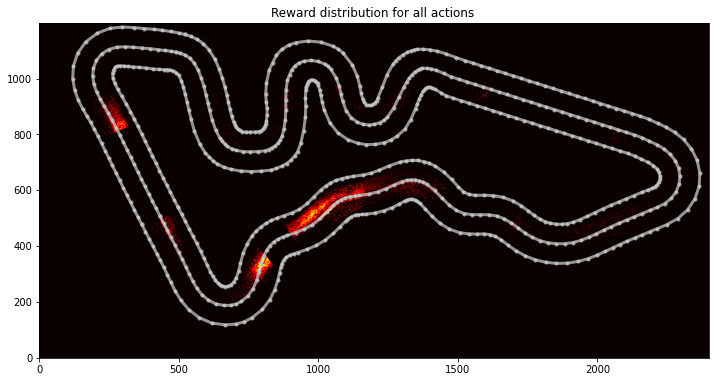

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 6: steering: -3.4, throttle: 5.0


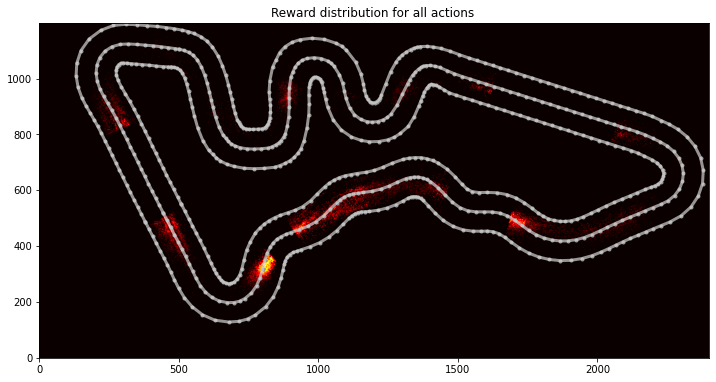

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 7: steering: -2.7, throttle: 2.5


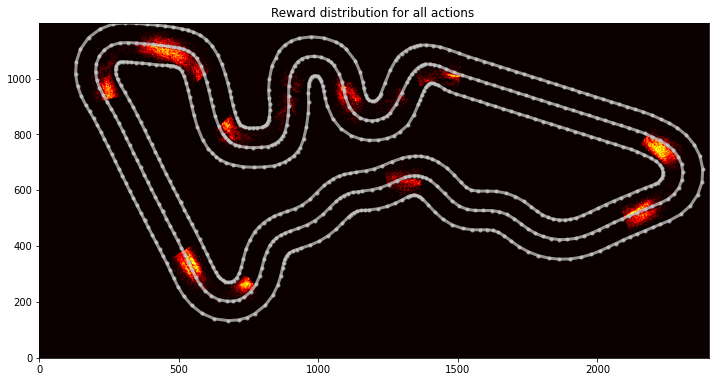

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 8: steering: -0.5, throttle: 4.9


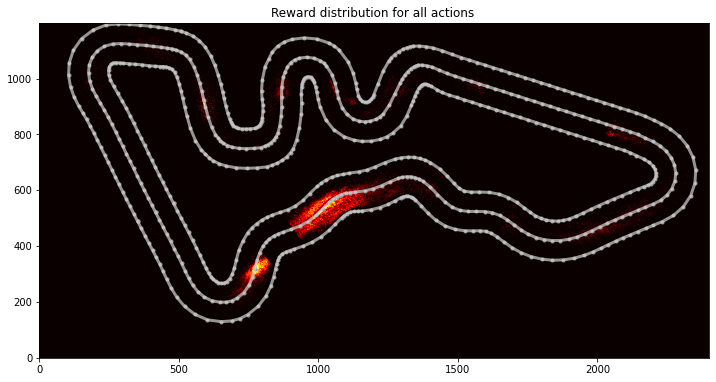

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 9: steering: -0.3, throttle: 7.0


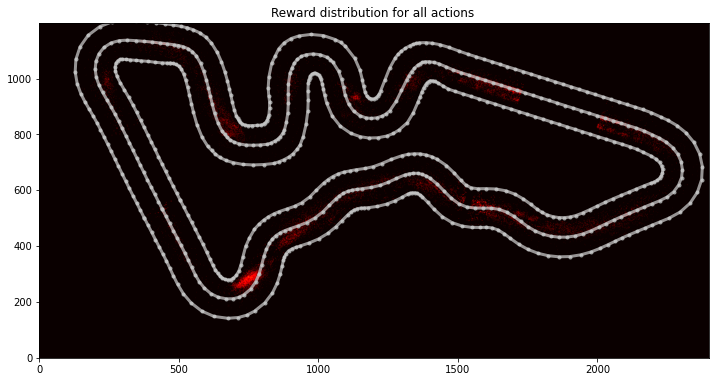

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 10: steering: 0.0, throttle: 8.0


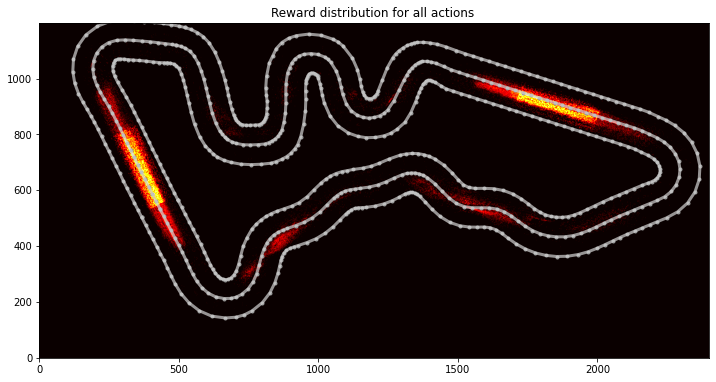

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 11: steering: 0.9, throttle: 7.0


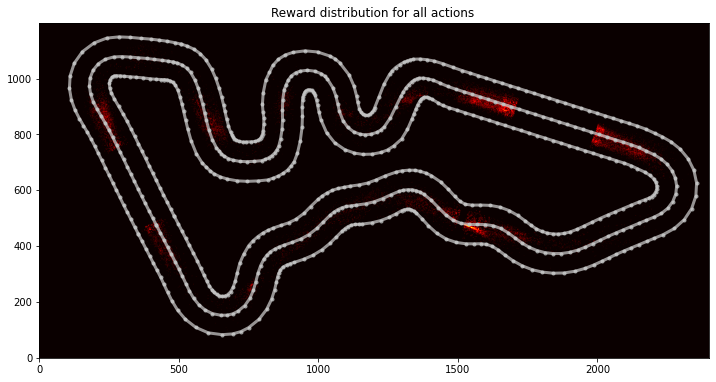

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 12: steering: 3.6, throttle: 2.6


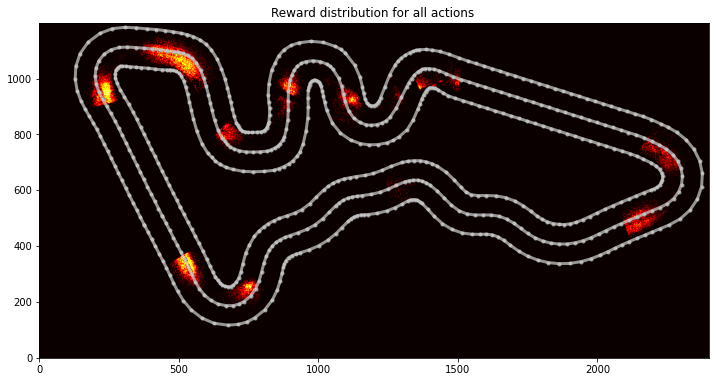

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 13: steering: 6.4, throttle: 4.0


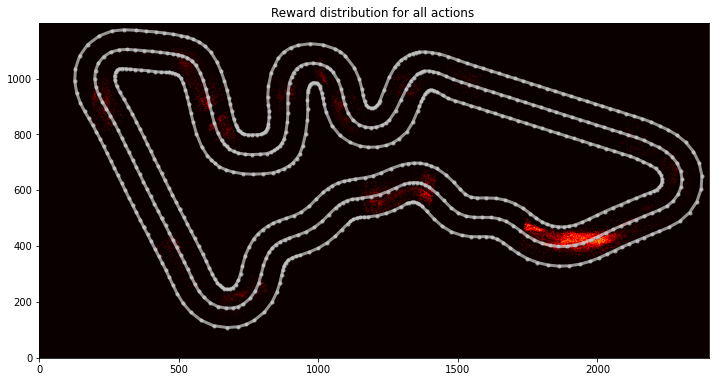

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 14: steering: 7.7, throttle: 3.5


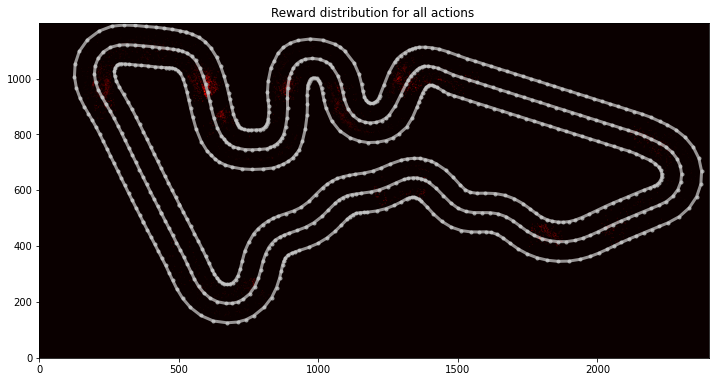

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 15: steering: 8.5, throttle: 1.5


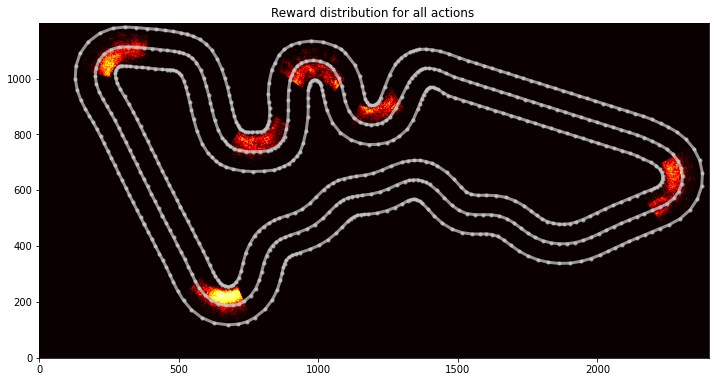

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 16: steering: 12.0, throttle: 3.7


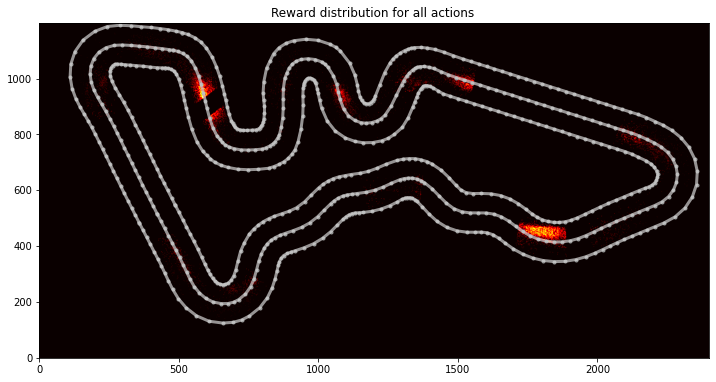

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 17: steering: 15.2, throttle: 2.4


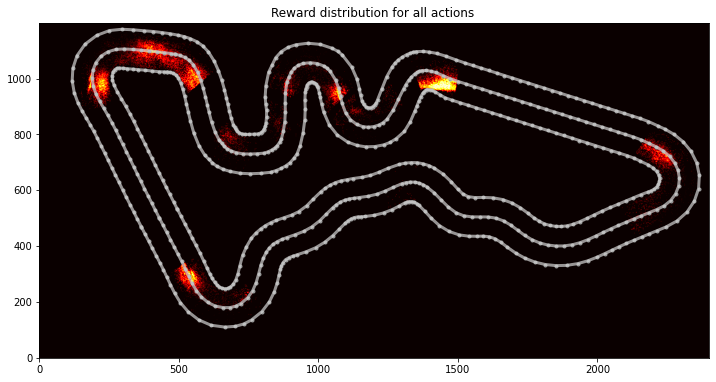

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 18: steering: 19.0, throttle: 1.5


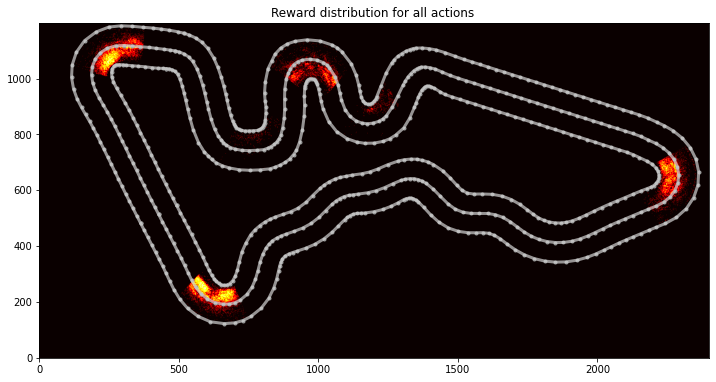

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 19: steering: 23.0, throttle: 1.4


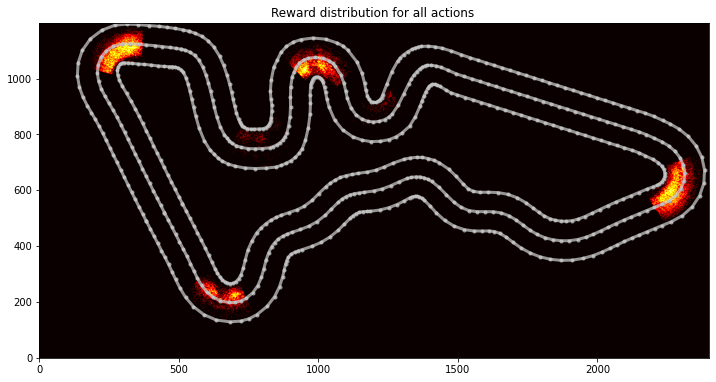

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 20: steering: 30.0, throttle: 1.2


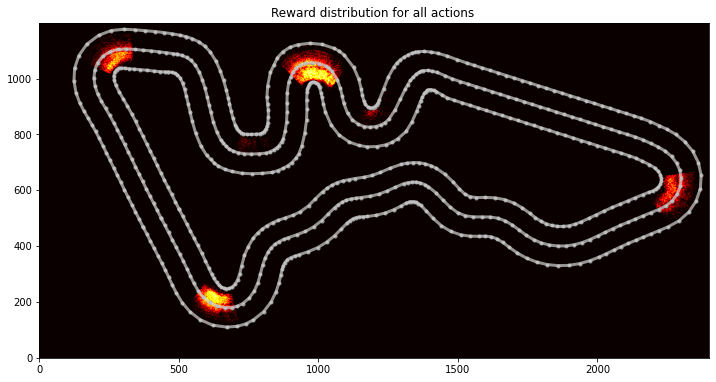

<Figure size 432x288 with 0 Axes>

In [47]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()

In [48]:
df[df['on_track']=='False'].count()[""]

KeyError: ''